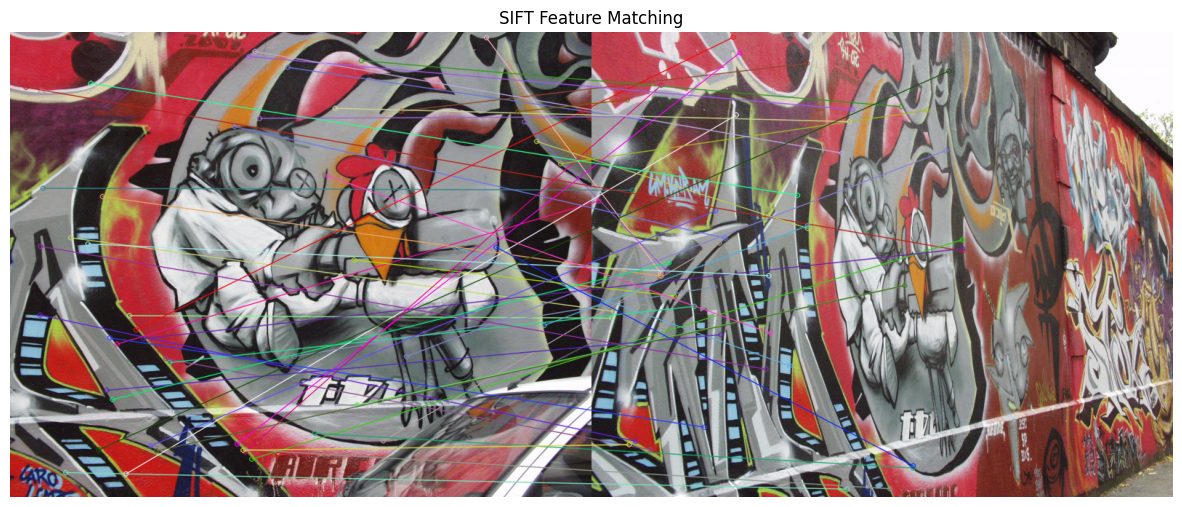

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the two images
image1 = cv2.imread('img1.ppm')
image2 = cv2.imread('img5.ppm')

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Use the Brute-Force Matcher to match descriptors between the two images
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Find the best matches
matches = bf.match(descriptors1, descriptors2)

# Sort the matches based on the distance (lower distance is better)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the matches between the two images (you can adjust the number of matches displayed)
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Convert BGR to RGB for displaying in Jupyter
matched_image_rgb = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

# Display the matched image
plt.figure(figsize=(15, 10))
plt.imshow(matched_image_rgb)
plt.title('SIFT Feature Matching')
plt.axis('off')  # Hide axes
plt.show()


## Q04 b


In [10]:
import cv2 as cv
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt

sift = cv.SIFT_create()

kp1, desc1 = sift.detectAndCompute(image1, None)
kp2, desc2 = sift.detectAndCompute(image2, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2)
good, pts1, pts2 = [], [], []

for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

good, pts1, pts2 = np.array(good), np.array(pts1), np.array(pts2)
matched_img = cv.drawMatchesKnn(image1, kp1, image2, kp2, good[:50], None, flags=2)

def homography(pts1, pts2):
    mean1, mean2 = np.mean(pts1, axis=0), np.mean(pts2, axis=0)
    s1, s2 = len(pts1)*np.sqrt(2)/np.sum(np.sqrt(np.sum((pts1-mean1)**2, axis=1))), len(pts1)*np.sqrt(2)/np.sum(np.sqrt(np.sum((pts2-mean2)**2, axis=1)))
    tx1, ty1, tx2, ty2 = -s1*mean1[0], -s1*mean1[1], -s2*mean2[0], -s2*mean2[1]
    T1, T2 = np.array(((s1, 0, tx1), (0, s1, ty1), (0, 0, 1))), np.array(((s2, 0, tx2), (0, s2, ty2), (0, 0, 1)))
    A = []

    for i in range(len(pts1)):
        X11, X21 = T1 @ np.concatenate((pts1[i], [1])).reshape(3, 1), T2 @ np.concatenate((pts2[i], [1])).reshape(3, 1)
        A.append((-X11[0][0], -X11[1][0], -1, 0, 0, 0, X21[0][0]*X11[0][0], X21[0][0]*X11[1][0], X21[0][0]))
        A.append((0, 0, 0, -X11[0][0], -X11[1][0], -1, X21[1][0]*X11[0][0], X21[1][0]*X11[1][0], X21[1][0]))
    
    A = np.array(A)
    U, S, V = np.linalg.svd(A, full_matrices=True)
    h = np.reshape(V[-1], (3, 3))
    H = linalg.inv(T2) @ h @ T1
    H = (1 / H.item(8)) * H
    return H
        
def dist(P1, P2, H):
    p1 = np.array([P1[0], P1[1], 1])
    p2 = np.array([P2[0], P2[1], 1])

    p2_estimate = np.dot(H, p1.T)
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate
    return np.linalg.norm(p2.T - p2_estimate)

def RANSAC_homography(points1, points2):
    inlier_count, selected_inliers = 0, None
    points = np.hstack((points1, points2))
    num_iterations = int(np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**4))
    
    for _ in range(num_iterations):
        np.random.shuffle(points)
        pts1, pts1_rem, pts2, pts2_rem = points[:4, :2],  points[4:, :2], points[:4, 2:], points[4:, 2:]
        H = homography(pts1, pts2)
        inliers = [(pts1_rem[i], pts2_rem[i]) for i in range(len(pts1_rem)) if dist(pts1_rem[i], pts2_rem[i], H) < 100]
        if len(inliers) > inlier_count:
            inlier_count = len(inliers)
            selected_inliers = np.array(inliers)
    
    H = homography(selected_inliers[:, 0], selected_inliers[:, 1])
    return H

H = RANSAC_homography(pts1, pts2)
print(H)



[[-2.76204721e-01 -3.36302031e-01  2.29736607e+02]
 [-3.64999511e-01 -5.31820731e-01  3.13121667e+02]
 [-1.17090013e-03 -1.66589404e-03  1.00000000e+00]]


## Q04 c

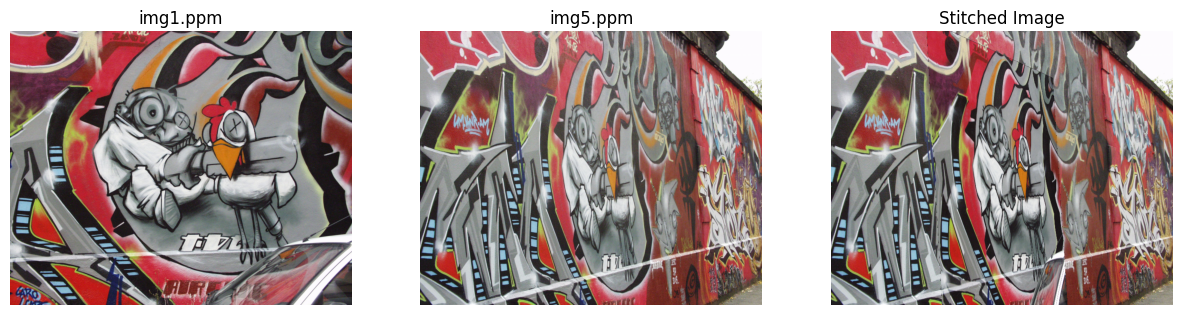

In [8]:
file = open(r"H1to5p", "r")
H = []

for _ in range(3):
    H.append(tuple(map(float, file.readline().strip().split())))

H = np.array(H)
img_p = cv2.warpPerspective(image1, H, (image2.shape[1], image2.shape[0]))
ret, threshold = cv2.threshold(img_p, 10, 1, cv2.THRESH_BINARY_INV)
img2_thresholded = np.multiply(threshold, image2)
img_blended = cv2.addWeighted(img2_thresholded, 1, img_p, 1, 0)

fig, ax = plt.subplots(1, 3, figsize=(15, 12))
ax[0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
ax[0].set_title("img1.ppm")
ax[0].axis("off")
ax[1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
ax[1].set_title("img5.ppm")
ax[1].axis("off")
ax[2].imshow(cv2.cvtColor(img_blended, cv2.COLOR_BGR2RGB))
ax[2].set_title("Stitched Image")
ax[2].axis("off")

# img_blended = cv2.circle(img_blended, (500, 600), 100, (0, 0, 255), 5)

# ax[3].imshow(img_blended)
# ax[3].set_title("Difference between Images")
# ax[3].axis("off")


plt.show()